In [5]:
'''
Lets you copy files from the notebook into your Google Drive
This is important for the CSVLogger, which tracks the loss and metrics
'''
#from google.colab import drive
#drive.mount('/content/drive/')

'\nLets you copy files from the notebook into your Google Drive\nThis is important for the CSVLogger, which tracks the loss and metrics\n'

In [23]:
#!pip install numpy
#!pip install pandas
#!pip install tensorflow
#!pip install matplotlib

In [7]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Supress INFO and WARNING messages
import warnings
warnings.filterwarnings('ignore')
# https://github.com/BundleOfKent/GradientDescentAnimation_NeuralNetwork/blob/main/NeuralNet_Medium.py

## Decouple w/ Sparse Data

In [8]:
'''
def y_final_time(x):
  return np.cos((np.pi / 2) * x)
def y_initial_time(x):
  return np.zeros_like(x)
'''
def g_fun(t, x): # This will be in the cost function
  return (0.5 * (np.square(u(t,x))))
def y_ref(t, x):
  # t needs to be a scalar
  # x can be a vector
  Pi = np.pi
  Pi2 = Pi*Pi
  Pi3 = Pi2*Pi
  Pihalf = Pi/2.0
  out = (2.0*(np.exp(-(Pi2*t)) - np.cos(Pihalf*t) + 2.0*Pi*np.sin(Pihalf*t))*np.sin(Pi*x))/(Pi + 4.0*Pi3)
  return out
  '''
  return 10.0*(np.power(np.pi,-2) + (-10.0 + np.pi*np.pi)\
      / (10.0*np.exp((np.pi*np.pi*t)/10.0) * np.pi*np.pi)\
      + np.cos(np.pi*x)/(5.0*np.exp((2.0*np.pi*np.pi*t)/5.0)))\
      * np.sin(np.pi*x)
  '''
def u_ref(t, x):
  return np.sin(np.pi*x) * np.sin(np.pi*t/2.0)

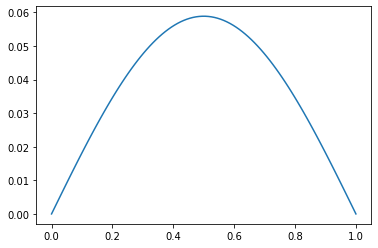

In [9]:
x_plot = np.linspace(0,1,100)
y_plot = y_ref(1/2, x_plot)
plt.plot(x_plot, y_plot)

## PINN Model Class

In [10]:
class PINNModel(keras.Model):
  # Initialize the model object
  def __init__(self, num_unit=100, debug=0):
    super(PINNModel, self).__init__()

    # Initialize the model object with the given hyperparameters
    #self.num_layer = hparams[HP_NUM_LAYER]
    self.num_unit = num_unit
    self.debug = debug

    self.u = None
    self.l = None
    self.y = None
    self.out = None
    self.f = None
    self.g = None
    self.dydxx = None
    self.dydt = None
    self.dldt = None
    self.dfdy = None
    self.dfdu = None
    self.dgdy = None
    self.dgdu = None
    self.pdeLoss = None
    self.systemPushBack = None
    self.systemControl = None

    # Layers of the neural network
    # https://github.com/tensorflow/tensorflow/issues/28799
    dim = (2,)
    dim = np.array(dim)
    act = 'elu'
    self.input_concat   = keras.layers.Concatenate(axis=1, name = 'input_concat')
    self.hidden_layer_1 = keras.layers.Dense(input_shape = dim, units=self.num_unit, name='hidden1', activation=act)
    self.hidden_layer_2 = keras.layers.Dense(units=self.num_unit, name='hidden2', activation=act)
    self.hidden_layer_3 = keras.layers.Dense(units=self.num_unit, name='hidden3', activation=act)
    self.hidden_layer_4 = keras.layers.Dense(units=self.num_unit, name='hidden4', activation=act)
    self.hidden_layer_5 = keras.layers.Dense(units=self.num_unit, name='hidden5', activation=act)
    self.hidden_layer_6 = keras.layers.Dense(units=self.num_unit, name='hidden6', activation=act)
    self.hidden_layer_7 = keras.layers.Dense(units=self.num_unit, name='hidden7', activation=act)
    self.hidden_layer_8 = keras.layers.Dense(units=self.num_unit, name='hidden8', activation=act)
    self.hidden_layer_9 = keras.layers.Dense(units=self.num_unit, name='hidden9', activation=act)
    self.hidden_layer_10 = keras.layers.Dense(units=self.num_unit, name='hidden10', activation=act)
    self.output_u_tilde = keras.layers.Dense(1, name='output_u_tilde')
    self.output_l_tilde = keras.layers.Dense(1, name='output_l_tilde')
    self.output_y_tilde = keras.layers.Dense(1, name='output_y_tilde')
    self.y_concat       = keras.layers.Concatenate(axis=1, name = 'y_concat')
    self.l_concat       = keras.layers.Concatenate(axis=1, name = 'l_concat')
    self.u_concat       = keras.layers.Concatenate(axis=1, name = 'u_concat')
    self.output_concat  = keras.layers.Concatenate(axis=1,  name = 'output_concat')

  def get_config(self):
    cfg = super().get_config()
    return cfg

  @classmethod
  def from_config(cls, config):
    return cls(**config)

  # Running the model
  def call(self, t, x):
    with tf.GradientTape(persistent=True) as tape, tf.GradientTape(persistent=True) as tape2:
      tape.watch(t)
      tape.watch(x)
        
      tx       = self.input_concat([t, x])
      h1       = self.hidden_layer_1(tx)
      h2       = self.hidden_layer_2(h1)
      h3       = self.hidden_layer_3(h2)
      h4       = self.hidden_layer_4(h3)
      h5       = self.hidden_layer_5(h4)
      y        = self.output_y_tilde(h5)
      u_input  = self.u_concat([y, h5])
      h6       = self.hidden_layer_6(u_input)
      h7       = self.hidden_layer_7(h6)
      h8       = self.hidden_layer_8(h7)
      u        = self.output_u_tilde(h8)
      l_input  = self.l_concat([y, u, h8])
      h9       = self.hidden_layer_9(l_input)
      h10      = self.hidden_layer_10(h9)
      l        = self.output_l_tilde(h10)
      out      = self.output_concat([y, l,  u])
      g        = tf.multiply(0.5, tf.square(u))

      dydx  = tape.gradient(y, x)
      dydxx = tape.gradient(dydx, x)
      f     = tf.add(u, tf.multiply(1.0,dydxx))
      #print('f: ', f)
      dfdy  = tape.gradient(f, y) # Derivative of f(y(t),u(t)) w.r.t. y
      #print('dfdy: ', dfdy)
      dydt  = tape.gradient(y, t) # Derivative of y w.r.t. t
      dldt  = tape.gradient(l, t) # Derivative of lambda (l) w.r.t. t
 
      dfdu  = tape.gradient(f, u) # Derivative of f(y(t),u(t)) w.r.t. u
      dgdy  = tape.gradient(g, y) # Derivative of g(y(t),u(t)) w.r.t. y
      dgdu  = tape.gradient(g, u) # Derivative of g(y(t),u(t)) w.r.t. u
      
      # Store various information in the model
      self.u = u
      self.l = l
      self.y = y
      self.f = f
      self.g = g
      self.dydx = dydx
      self.dydxx = dydxx
      self.dydt = dydt
      self.dldt = dldt
      self.dfdy = dfdy
      self.dfdu = dfdu
      self.dgdy = dgdy
      self.dgdu = dgdu

    # Fourth term of extended loss function
    pdeLoss = tf.subtract(dydt, f)
    pdeLoss = tf.reduce_sum(tf.square(pdeLoss))
    self.add_loss(pdeLoss)
    self.pdeLoss = pdeLoss

    # Fifth term of extended loss function
    systemPushBack = tf.add(dldt, tf.multiply(dfdy, l))
    systemPushBack = tf.add(systemPushBack, dgdy)
    systemPushBack = tf.reduce_sum(tf.square(systemPushBack))
    self.add_loss(systemPushBack)
    self.systemPushBack = systemPushBack

    # Sixth term of extended loss function
    systemControl = tf.add(tf.multiply(dfdu, l), dgdu)
    systemControl = tf.reduce_sum(tf.square(systemControl))
    self.add_loss(systemControl)
    self.systemControl = systemControl

    if (self.debug == 0):
      print('syspushback: ', systemPushBack)
      print('syscontrol: ', systemControl)
      print('pdeloss: ', pdeLoss)
  
    return out

  def calc_costs(self, t):
    warnings.filterwarnings('ignore')
    t = tf.constant(np.asarray(t).reshape(-1,1))
    self.store_derivatives(t)
    print(
        f'Custom Loss Components:\n'
        f'pdeLoss: {self.pdeLoss}, \n'
        f'systemPushBack: {self.systemPushBack}, \n'
        f'systemControl: {self.systemControl}, \n'
    )
    return [self.pdeLoss, self.systemPushBack, self.systemControl]
  



In [11]:
def dummy_loss(y, yt):
  return tf.reduce_sum(tf.square(tf.subtract(y,yt)))
model = PINNModel()
optim  =  keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer = optim , loss = keras.losses.MSE, metrics = keras.metrics.MSE)
import warnings 
warnings.filterwarnings('ignore')
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # TODO: Change to adaptive and smaller step size
loss_fn = tf.keras.losses.MSE
loss_fn = dummy_loss

In [12]:
optimizer.learning_rate.assign(1e-3)
#loss_fn = dummy_loss
epochs              = 200
steps               = 1
model.debug         = 1
innerIterations     = 1
t_initial = 0.0
t_final = 1.0
x_initial = 0.0
x_final = 1.0

num_x_points = 1000
num_t_points = num_x_points
batchSize = num_x_points
w_pdeLoss = 1e-1
w_systemPushback = 1e-1
w_systemControl = 1e-1

for epoch in range(epochs):
  # Iterate over the batches of a dataset.

  for step in range(steps):
    
    #Space batch points
    x_batch_train = np.random.uniform(x_initial, x_final, num_x_points).astype('float32')
    # Final time
    y_final_time_train = y_ref(t_final, x_batch_train)
    # Initial time
    y_initial_time_train = y_ref(t_initial, x_batch_train)
    
    # Time batch points
    t_batch_train = np.random.uniform(t_initial, t_final, num_t_points).astype('float32')
    
    with tf.GradientTape() as tape1:
        
      # Boundary Condition 1
      bc_1_t = tf.reshape(tf.constant(t_batch_train, dtype='float32'), (-1,1))
      bc_1_x = tf.reshape(tf.constant(np.repeat(x_initial, num_t_points), dtype='float32'), (-1,1))
      
      
      
      out = model(bc_1_t, bc_1_x)
    
      loss_value_at_bc1 = tf.reduce_sum(
          loss_fn(np.zeros((1,num_t_points), dtype='float32'), out[:,0]))
      
      # Boundary Condition 2
      bc_2_t = tf.reshape(tf.constant(t_batch_train, dtype='float32'), (-1,1))
      bc_2_x = tf.reshape(tf.constant(np.repeat(x_final, num_t_points), dtype='float32'), (-1,1))
      
      out = model(bc_2_t, bc_2_x)
      loss_value_at_bc2 = tf.reduce_sum(
          loss_fn(np.zeros((1,num_t_points), dtype='float32'), out[:,0]))

            
      # Final Time
      out = model(tf.reshape(tf.constant(np.repeat(t_final, num_x_points)), (-1,1)),
                  tf.reshape(tf.constant(x_batch_train), (-1,1)))
      loss_value_at_final_time = tf.reduce_sum(loss_fn(y_final_time_train,
                                                       out[:,0]))
    
      
      
#       plt.scatter(x_batch_train, y_final_time_train)
#       break
      # Initial Time
      out = model(tf.reshape(tf.constant(np.repeat(t_initial, num_x_points)),(-1,1)),
                  tf.reshape(x_batch_train,(-1,1)))
      loss_value_at_initial_time = tf.reduce_sum(loss_fn(y_initial_time_train,
                                                         out[:,0])) # Does this output all batches?
      
      loss_value = loss_value_at_final_time\
                 + loss_value_at_initial_time\
                 + loss_value_at_bc1\
                 + loss_value_at_bc2
        

      # Add extra losses created during this forward pass:
      pinnloss = model.losses[0] * w_pdeLoss\
               + model.losses[1] * w_systemPushback\
               + model.losses[2] * w_systemControl
      #loss_value = loss_value + epoch * 0. * pinnloss # DO WE NEED THIS NOW???
    
      

      for i in range(innerIterations):
        # subsample time
        sampleResidualPoints = np.random.uniform(x_initial, x_final, size=batchSize) 
        sampleResidualTimes  = np.random.uniform(t_initial, t_final, size=batchSize) 
        sampleResidualPoints = sampleResidualPoints.astype('float32')
        sampleResidualTimes  = sampleResidualTimes.astype('float32')
        out = model(tf.reshape(tf.constant(sampleResidualTimes), (-1,1)),
                  tf.reshape(tf.constant(sampleResidualPoints), (-1,1)))
        # Add extra losses created during this forward pass:
        #pinnloss  += sum(model.losses) # Need to do weighted sum
        pinnloss += model.losses[0] * w_pdeLoss\
                  + model.losses[1] * w_systemPushback\
                  + model.losses[2] * w_systemControl
      
      loss_value = ((pinnloss / innerIterations) / batchSize) + loss_value

    #### Apply gradient based on labeled data
    grads = tape1.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    print(
      f'Epoch {epoch + 1}, '
      f'Step {step}, '
      f'Total Loss: {loss_value}, '
      f'PINN Loss: {pinnloss}')

Epoch 1, Step 0, Total Loss: 24.495712280273438, PINN Loss: 7.754806995391846
Epoch 2, Step 0, Total Loss: 301.37158203125, PINN Loss: 59.148223876953125
Epoch 3, Step 0, Total Loss: 31.11214828491211, PINN Loss: 5.24199104309082
Epoch 4, Step 0, Total Loss: 75.49247741699219, PINN Loss: 11.608888626098633
Epoch 5, Step 0, Total Loss: 133.43893432617188, PINN Loss: 16.63235092163086
Epoch 6, Step 0, Total Loss: 86.04097747802734, PINN Loss: 9.681673049926758
Epoch 7, Step 0, Total Loss: 24.95975685119629, PINN Loss: 4.87410831451416
Epoch 8, Step 0, Total Loss: 9.724164009094238, PINN Loss: 5.6921210289001465
Epoch 9, Step 0, Total Loss: 29.744853973388672, PINN Loss: 8.269786834716797
Epoch 10, Step 0, Total Loss: 48.424468994140625, PINN Loss: 9.395397186279297
Epoch 11, Step 0, Total Loss: 43.86040496826172, PINN Loss: 9.706405639648438
Epoch 12, Step 0, Total Loss: 27.283185958862305, PINN Loss: 9.08922004699707
Epoch 13, Step 0, Total Loss: 11.522868156433105, PINN Loss: 7.3459367

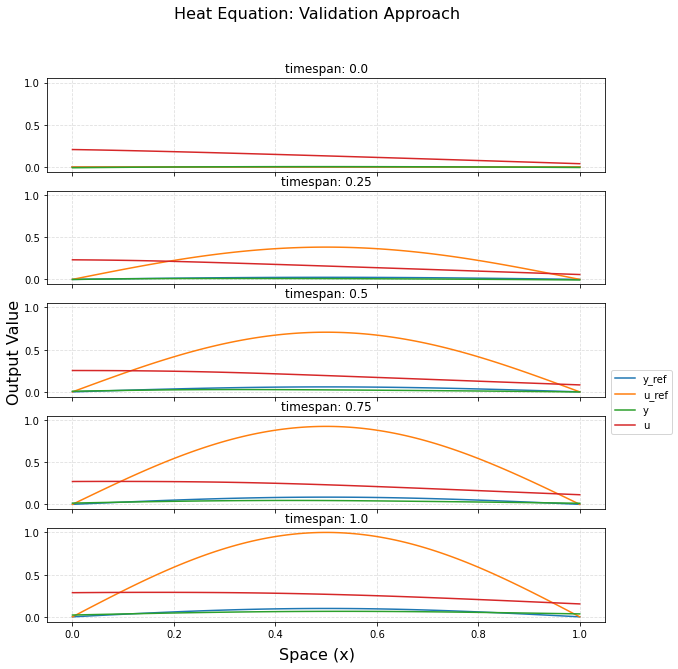

In [13]:
x_plot = np.linspace(0,1,100)
x_plot = x_plot.astype('float32')
timespan = 0.0
timespans = [0.0, 0.25, 0.5, 0.75, 1.0]

fig, axs = plt.subplots(5, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle('Heat Equation: Validation Approach', size=16)
fig.text(0.5, 0.08, 'Space (x)', ha='center',va='center', size=16)
fig.text(0.08, 0.5, 'Output Value', ha='center',va='center', rotation='vertical', size=16)
for i in range(len(timespans)):
  axs[i].grid(alpha=.4, linestyle='--')
  axs[i].plot(x_plot, y_ref(timespans[i], x_plot), label='y_ref')
  axs[i].plot(x_plot, u_ref(timespans[i], x_plot), label='u_ref')
  pred = model(tf.reshape(tf.constant(np.repeat(timespans[i], 100)),(-1,1)),
            tf.reshape(tf.constant(x_plot), (-1,1)))
  axs[i].plot(x_plot, pred[:,0], label='y')
  axs[i].plot(x_plot, pred[:,2], label='u')
  #axs[i].plot(x_plot, pred[:,1], label='l')
  axs[i].set_title(f'timespan: {timespans[i]}',fontsize=12)

plt.legend(loc=(1.01, 2))
plt.savefig('ControlPINN_HeatEq_GridPlot.png')


In [14]:
!cp ControlPINN_HeatEq_GridPlot.png '/content/drive/My Drive/ControlPINN_HeatEq_GridPlot.png'


'cp' is not recognized as an internal or external command,
operable program or batch file.


In [20]:
'''
Offline data generation of control u.
The model predicts on the whole space (x)
for each time step.

Shape of dataset generated:
    t x    u
0   0 0    0.123
1   0 0.01 0.123
'''
def get_u_data(timespan, spacespan):
  timespan = timespan.astype('float32')
  spacespan = spacespan.astype('float32')
  dataset = []
  for time in timespan:
    t = np.repeat(time, len(spacespan))
    t_np = t.astype('float32')            # NumPy arrays to write to csv
    t = tf.reshape(tf.constant(t_np), (-1,1))
    x_np = spacespan.astype('float32')    # NumPy arrays to write to csv
    x = tf.reshape(tf.constant(x_np),(-1,1))

    out = model(t, x)
    u = out[:,2] # output = [y, l, u]
    mat = np.array([t_np, x_np, u]).T
    dataset.append(mat)

  dataset = np.array(dataset)
  dataset = np.reshape(dataset, (len(timespan)*len(spacespan), 3))
  return np.asarray(dataset) # Return dataset as NumPy array


In [21]:
t = np.linspace(0,1,100)#np.random.uniform(0.0, 1.0, 100)
x = np.linspace(0,1,100)#np.random.uniform(0.0, 1.0, 100)
dataset = get_u_data(t, x)
df = pd.DataFrame(dataset, columns=['t', 'x', 'u'])
df.to_csv('u_data.csv')

In [22]:
print(df)

        t         x         u
0     0.0  0.000000 -0.278104
1     0.0  0.010101 -0.280100
2     0.0  0.020202 -0.282006
3     0.0  0.030303 -0.283830
4     0.0  0.040404 -0.285578
...   ...       ...       ...
9995  1.0  0.959596 -0.331951
9996  1.0  0.969697 -0.332171
9997  1.0  0.979798 -0.332391
9998  1.0  0.989899 -0.332613
9999  1.0  1.000000 -0.332834

[10000 rows x 3 columns]


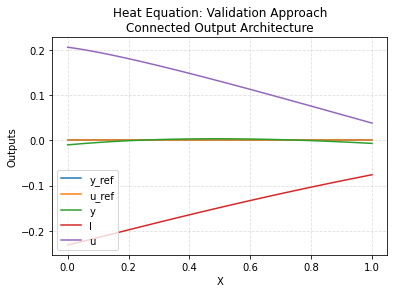

In [15]:
x_plot = np.linspace(0,1,100)
x_plot = x_plot.astype('float32')

timespan = 0.0

plt.plot(x_plot, y_ref(timespan, x_plot), label='y_ref')
plt.plot(x_plot, u_ref(timespan, x_plot), label='u_ref')
#plt.plot(timespan, lambda_star, label='lambda_star')
plt.title('Heat Equation: Validation Approach\nConnected Output Architecture')
plt.xlabel('X')
plt.ylabel('Outputs')
plt.grid(alpha=.4, linestyle='--')
pred = model(tf.reshape(tf.constant(np.repeat(timespan, 100)),(-1,1)),
          tf.reshape(tf.constant(x_plot), (-1,1)))
plt.plot(x_plot, pred[:,0], label='y')
plt.plot(x_plot, pred[:,1], label='l')
plt.plot(x_plot, pred[:,2], label='u')
plt.legend(loc='lower left')
#plt.text(5, 10, timespan)
#plt.show()
plt.savefig('ControlPINN_HeatEq_ConnectedOutput_200Epochs.png')

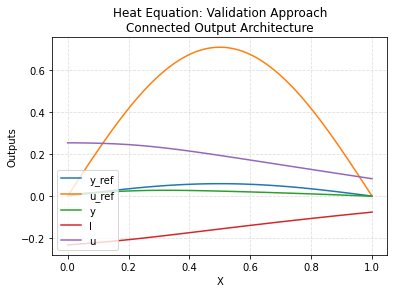

In [16]:
x_plot = np.linspace(0,1,100)
x_plot = x_plot.astype('float32')

timespan = 0.5

plt.plot(x_plot, y_ref(timespan, x_plot), label='y_ref')
plt.plot(x_plot, u_ref(timespan, x_plot), label='u_ref')
#plt.plot(timespan, lambda_star, label='lambda_star')
plt.title('Heat Equation: Validation Approach\nConnected Output Architecture')
plt.xlabel('X')
plt.ylabel('Outputs')
plt.grid(alpha=.4, linestyle='--')
pred = model(tf.reshape(tf.constant(np.repeat(timespan, 100)),(-1,1)),
          tf.reshape(tf.constant(x_plot), (-1,1)))
plt.plot(x_plot, pred[:,0], label='y')
plt.plot(x_plot, pred[:,1], label='l')
plt.plot(x_plot, pred[:,2], label='u')
plt.legend(loc='lower left')
#plt.text(5, 10, timespan)
#plt.show()
plt.savefig('ControlPINN_HeatEq_ConnectedOutput_200Epochs.png')

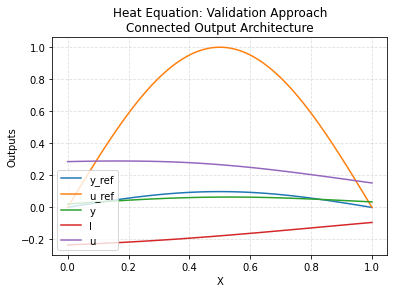

In [17]:
x_plot = np.linspace(0,1,100)
x_plot = x_plot.astype('float32')

timespan = 1.0

plt.plot(x_plot, y_ref(timespan, x_plot), label='y_ref')
plt.plot(x_plot, u_ref(timespan, x_plot), label='u_ref')
#plt.plot(timespan, lambda_star, label='lambda_star')
plt.title('Heat Equation: Validation Approach\nConnected Output Architecture')
plt.xlabel('X')
plt.ylabel('Outputs')
plt.grid(alpha=.4, linestyle='--')
pred = model(tf.reshape(tf.constant(np.repeat(timespan, 100)),(-1,1)),
          tf.reshape(tf.constant(x_plot), (-1,1)))
plt.plot(x_plot, pred[:,0], label='y')
plt.plot(x_plot, pred[:,1], label='l')
plt.plot(x_plot, pred[:,2], label='u')
plt.legend(loc='lower left')
#plt.text(5, 10, timespan)
#plt.show()
plt.savefig('ControlPINN_HeatEq_ConnectedOutput_200Epochs.png')

In [18]:
!cp ControlPINN_HeatEq_ConnectedOutput_200Epochs.png '/content/drive/My Drive/ControlPINN_HeatEq_ConnectedOutput_200Epochs.png'

'cp' is not recognized as an internal or external command,
operable program or batch file.


# Scratch pad

In [19]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2) # TODO: Change to adaptive and smaller step size
loss_fn = tf.keras.losses.MSE
#loss_fn = dummy_loss
epochs              = 1
model.debug         = 1
innerIterations     = 1
t_initial = 0.0
t_final = 1.0
x_initial = 0.0
x_final = 1.0
y0 = 1.0
num_x_points = 64
batchSize = 64
w_pdeLoss = 1
w_systemPushback = 1e4
w_systemControl = 1e4

for epoch in range(epochs):
  # Iterate over the batches of a dataset.
  steps = 100
  for step in range(steps):
    x_batch_train = np.random.uniform(x_initial, x_final, num_x_points) / 1.0
    x_batch_train = x_batch_train.astype('float32')
    y_final_time_train = y_ref(1.0, x_batch_train)
    y_initial_time_train = y_ref(0.0, x_batch_train)
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
      # Final Time
      out = model(tf.reshape(tf.constant(np.repeat(t_final, num_x_points)), (-1,1)),
                  tf.reshape(tf.constant(x_batch_train), (-1,1)))
      loss_value_at_final_time = tf.reduce_sum(loss_fn(y_final_time_train,
                                                       out[:,0]))
      
      # Initial Time
      out = model(tf.reshape(tf.constant(np.repeat(t_final, num_x_points)),(-1,1)),
                  tf.reshape(x_batch_train,(-1,1)))
      loss_value_at_initial_time = tf.reduce_sum(loss_fn(y_initial_time_train,
                                                         out[:,0]))
      
      #print(f'Loss at Final Time: {loss_value_at_final_time}\n'
      #      f'Loss at Initial Time: {loss_value_at_initial_time}')
      #break
      
      loss_value = loss_value_at_final_time + loss_value_at_initial_time
      # Add extra losses created during this forward pass:
      pinnloss  = sum(model.losses)
      #loss_value = loss_value + epoch * 0. * pinnloss # DO WE NEED THIS NOW???

      for i in range(innerIterations):
        # subsample time
        sampleResidualPoints = np.random.uniform(0, 1, size=batchSize) / 1.0
        sampleResidualTimes  = np.random.uniform(0, 1, size=batchSize) / 1.0
        sampleResidualPoints = sampleResidualPoints.astype('float32')
        sampleResidualTimes  = sampleResidualTimes.astype('float32')
        out = model(tf.reshape(tf.constant(sampleResidualTimes), (-1,1)),
                  tf.reshape(tf.constant(sampleResidualPoints), (-1,1)))
        # Add extra losses created during this forward pass:
        #pinnloss  += sum(model.losses) # Need to do weighted sum
        pinnloss += model.losses[0] * w_pdeLoss\
                  + model.losses[1] * w_systemPushback\
                  + model.losses[2] * w_systemControl
      
      loss_value = ((pinnloss / innerIterations) / batchSize) + loss_value

    #### Apply gradient based on labeled data
    grads = tape1.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    print(
      f'Epoch {epoch + 1}, '
      f'Step {step}, '
      f'Loss at Final Time: {loss_value_at_final_time}, '
      f'Loss at Initial Time: {loss_value_at_initial_time}')

Epoch 1, Step 0, Loss at Final Time: 0.0005192018579691648, Loss at Initial Time: 0.0026760855689644814
Epoch 1, Step 1, Loss at Final Time: 0.3491702079772949, Loss at Initial Time: 0.28049570322036743
Epoch 1, Step 2, Loss at Final Time: 0.09227782487869263, Loss at Initial Time: 0.13420194387435913
Epoch 1, Step 3, Loss at Final Time: 0.037286289036273956, Loss at Initial Time: 0.01840229146182537
Epoch 1, Step 4, Loss at Final Time: 0.05339076370000839, Loss at Initial Time: 0.06531944870948792
Epoch 1, Step 5, Loss at Final Time: 0.08001163601875305, Loss at Initial Time: 0.06822697818279266
Epoch 1, Step 6, Loss at Final Time: 0.11369192600250244, Loss at Initial Time: 0.07913762331008911
Epoch 1, Step 7, Loss at Final Time: 0.03105452097952366, Loss at Initial Time: 0.011554836295545101
Epoch 1, Step 8, Loss at Final Time: 0.20842479169368744, Loss at Initial Time: 0.15370796620845795
Epoch 1, Step 9, Loss at Final Time: 0.3997592329978943, Loss at Initial Time: 0.32758298516273